<a href="https://colab.research.google.com/github/Anggunasr/MSBA2425/blob/ADA/8_1_LSTM_for_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM for Forecasting
This tutorial will walk you through fitting an LSTM model to data on airline passengers (a forecasting problem).

You will get the change to play with the parameters and see what works best.

Let's start with some libraries!

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Step 1: Load and Preprocess the Dataset
We'll use the "Airline Passengers" dataset which is available at: https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv.

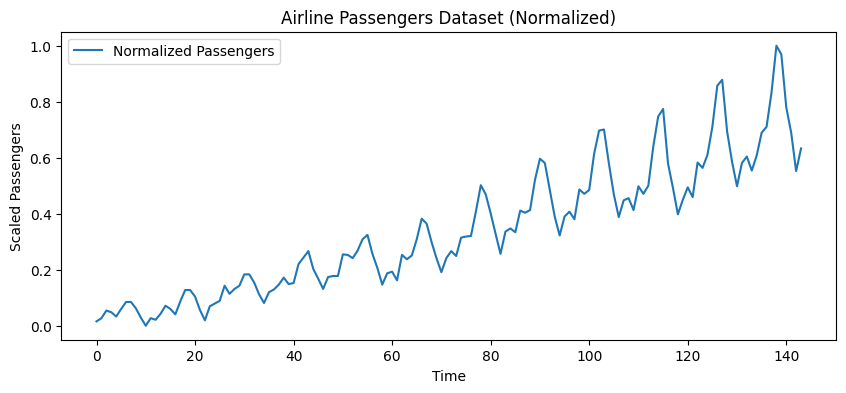

In [2]:
# Load the dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, usecols=[1])  # Only load the passenger count column
data = df.values.astype(float)

# Normalise the data using min-max
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Plot the data for visual inspection
plt.figure(figsize=(10, 4))
plt.plot(data_scaled, label="Normalized Passengers")
plt.title("Airline Passengers Dataset (Normalized)")
plt.xlabel("Time")
plt.ylabel("Scaled Passengers")
plt.legend()
plt.show()


Supspiciously clean data I know but let's see what happens :)

## Step 2: Create a Time Series Dataset
We will use a sliding window approach to convert the time series into samples. You can experiment with different seq_length values.

In [13]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        x = self.data[index: index + self.seq_length]
        y = self.data[index + self.seq_length]
        return torch.FloatTensor(x), torch.FloatTensor(y)

# Set the sequence length (modifiable parameter)
seq_length = 6  # Try changing this (e.g., 6, 12, 24)
dataset = TimeSeriesDataset(data_scaled, seq_length)

# Split dataset into train and test sets (e.g., 80/20 split)
# Why are we not using TrainTestSplit?
train_size = int(len(dataset) * 0.8) # 80% of training
test_size = len(dataset) - train_size

train_dataset = TimeSeriesDataset(data_scaled[:train_size+seq_length], seq_length)  # Include seq_length to cover the entire training set
test_dataset = TimeSeriesDataset(data_scaled[train_size:], seq_length)  # Start from where training set ends

# Create DataLoaders
batch_size = 8 # batch size of 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Step 3: Define the LSTM Model
Below is a basic LSTM model. You can modify hyperparameters such as the hidden size, number of layers, dropout and bi-directionality.

In [42]:
class LSTMForecast(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1, dropout=0.2, bidirectional=False):
        super(LSTMForecast, self).__init__()
        self.hidden_size = hidden_size # hyperparameter
        self.num_layers = num_layers # hyperparameter

        #
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Get the last time step output
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# Instantiate the model with modifiable hyperparameters
input_size = 1
hidden_size = 100      # Try modifying (e.g., 30, 50, 100) -- this is number of neurons, so the higher it's then it's expected to have lower loss
num_layers = 3        # Try modifying (e.g., 1, 2, 3)  -- this number may lead to overfit if the data is not that many - the input w
output_size = 1        # Size 1 as its regression
dropout = 0.2          # Try modifying dropout rate
bidirectional = False  # Should we allow a bidirectional LSTM?

# (num_layers, hidden_layers)
# higher num of layers (3)(100): 0.0013, (3)(50): 0.0086, (3)(50): 0.0085, (2)(100): 0.0008, (2)(50): 0.0014, (2)(30): Loss: 0.0006
model = LSTMForecast(input_size, hidden_size, num_layers, output_size, dropout).to(device)
print(model)


LSTMForecast(
  (lstm): LSTM(1, 100, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)


## Step 4: Train the Model
Set up the loss function and optimiser, and train the model. We won't use validation as the dataset is quite small (and therefore no early stopping).

In [43]:
criterion = nn.MSELoss() # could change this if you want
optimiser = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0005)  # You may change the learning rate

num_epochs = 200  # Modify the number of epochs if needed

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device) # to GPU
        y_batch = y_batch.to(device)

        # Zero gradients
        optimiser.zero_grad()

        # Forward pass
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimiser.step()

        epoch_loss += loss.item()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {round(epoch_loss/len(train_loader), 4)}")


Epoch [10/200], Loss: 0.0382
Epoch [20/200], Loss: 0.0365
Epoch [30/200], Loss: 0.0357
Epoch [40/200], Loss: 0.0356
Epoch [50/200], Loss: 0.0353
Epoch [60/200], Loss: 0.0353
Epoch [70/200], Loss: 0.0355
Epoch [80/200], Loss: 0.0373
Epoch [90/200], Loss: 0.0582
Epoch [100/200], Loss: 0.0301
Epoch [110/200], Loss: 0.0246
Epoch [120/200], Loss: 0.0176
Epoch [130/200], Loss: 0.0107
Epoch [140/200], Loss: 0.007
Epoch [150/200], Loss: 0.0108
Epoch [160/200], Loss: 0.0073
Epoch [170/200], Loss: 0.0082
Epoch [180/200], Loss: 0.0083
Epoch [190/200], Loss: 0.0067
Epoch [200/200], Loss: 0.0068


## Step 5: Evaluate the Model
Plot predictions versus actual values on the test set.

Epoch [200/200], Loss: 0.0013


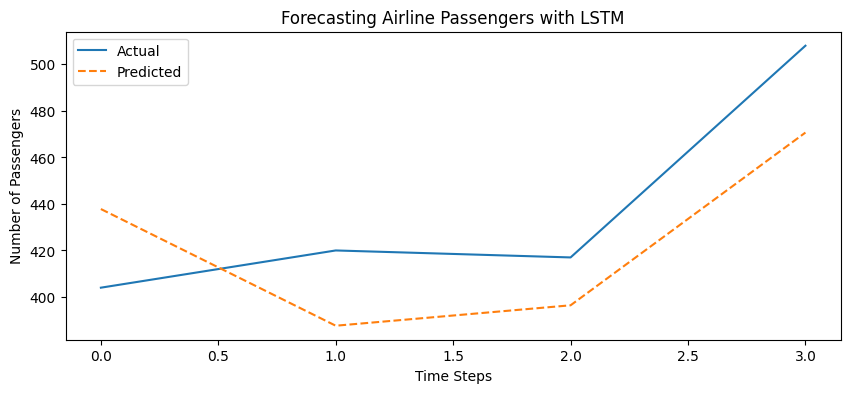

In [44]:
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
      epoch_loss = 0
      x_batch = x_batch.to(device)
      output = model(x_batch)
      predictions.append(output.cpu().numpy().flatten()[0])
      actuals.append(y_batch.numpy().flatten()[0])

      epoch_loss += loss.item()

    if (epoch+1) % 1 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {round(epoch_loss/len(train_loader), 4)}")

# Inverse transform to original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

# Plotting results
plt.figure(figsize=(10, 4))
plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted", linestyle='--')
plt.title("Forecasting Airline Passengers with LSTM")
plt.xlabel("Time Steps")
plt.ylabel("Number of Passengers")
plt.legend()
plt.show()

Looks pretty good! But could it be better? ...

### Exercise
Try changing some of the parameters of the model and see if you can improve it. In particular look at the sequence length and module architecture.